In [1]:
import glob, os, random, re, sys
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import scipy.ndimage as ndi
import skimage.filters as flt
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from scipy.signal import convolve2d
from skimage.io import imread, imsave
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects
from ipywidgets import interact, widgets
from IPython.display import set_matplotlib_formats

%matplotlib inline
%config InlineBackend.figure_format ='retina'

# FISH colocalization with granules
***

This notebook is part of my master thesis titled: "Single-molecule imaging of mRNA to study translational regulation".

## Colocalization overview

1. [Image import](#section1)
2. [DAPI-gated cellular segmentation](#section2)
3. [Colocalization analysis](#section3)
4. [Spot detection](#section4)
5. [Cell-to-cell measurements](#section5)
6. [Batch processing](#section6)
7. [Data analysis](#section7)
8. [(Functions)](#section8)

In this experiment, we wanted to determine if a new construct containing standard-MCP-Halo-G3BP1 is able to recruit reporter mRNAs to stress granules with a higher efficacy compared to a construct without G3BP1. Three different mRNAs (pIM52, pIM52-CMV-5'TOP, ATF-4) will be used.

As positive control, luminescent beads will be used for 'perfect' colocalization. A singly labeled sample (either granules or FISH) will be used to measure the effect of crosstalk and serves as negative control.

The previously constructed pipeline for OptoGranule induction will be used to test wether the FISH (mRNA) and the granule signals colocalize. This pipeline will segment cells based on their DAPI signal and measure colocalization as well as count the number of granules in each cell.

Lastly, some of the subsequent code was adapted from the European Molecular Biology Laboratory, Jonas Hartmann, Karin Sasaki, Toby Hodges (© 2018, for cellular segmentation) and from Justin Bois, California Institute of Technology (© 2015, for colocalization). Everything is distributed under a MIT license.

<a id='section1'></a>
# 1. Image import

First, the images are imported as numpy array. The filetype (here: .stk) must be specified in order to import the correct images. Once imported, the images are displayed for visual inspection. The channels should be labeled as indicated below.

- Image 0 – Nuclear label (eg. DAPI) – here: DAPI, 405 nm
- Image 1 – Colocalization 1 (eg. Halo or IF) – here: OptoG-mRuby, 561 nm
- Image 2 – Colocalization 2 (eg. FISH) – here: FISH-Renilla, 640 nm

The subsequent sharp function is used to determine the sharpest slice of the z-stack images. This is done by measuring the average intensity differences between pixel values.

In [2]:
def sharp(img):
    '''
    Returns index of the sharpest slice in an image array of shape z, x, y.
    '''
    sharpness = []
    array = np.asarray(img, dtype=np.int32)
    for i in range(array.shape[0]):
        y, x = np.gradient(array[i])
        norm = np.sqrt(x**2 + y**2)
        sharpness.append(np.average(norm))
    return sharpness.index(max(sharpness))

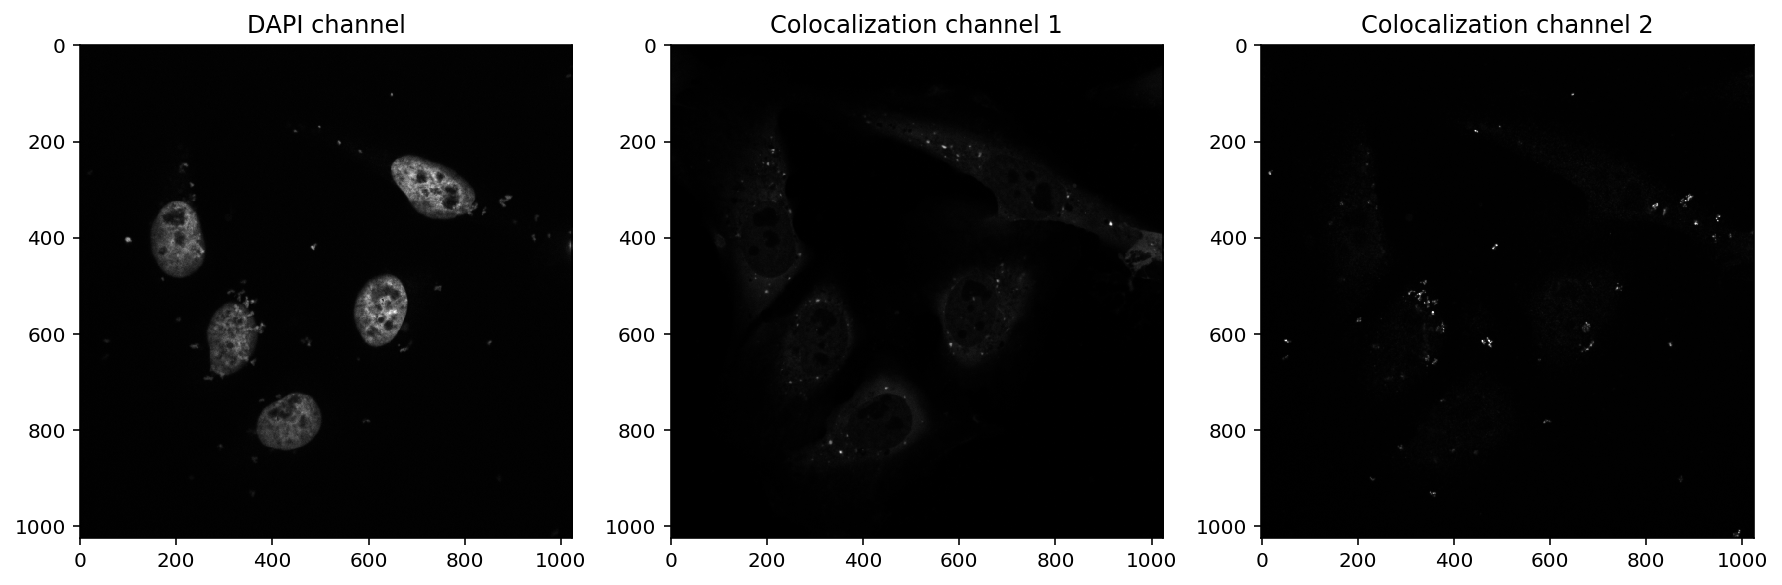

In [3]:
# File path
index = 'example'
root = 'colocalization_example/'
outfolder = 'colocalization_example/'
lambdas = [405, 561, 640]

# Listing all files with index and .stk extension
files = glob.glob('{}{}*.stk'.format(root, index))

# Find sharpest image in img2_lambda channel
for f in files:
    if str(lambdas[2]) in f:
        img_sharp = sharp(imread(f))

# Open all images corresponding to a lambda
for f in files:
    for i in range(len(lambdas)):
        if str(lambdas[i]) in f:
            globals()['img_'+str(lambdas[i])] = imread(f)[img_sharp]

# Stack and convert to uint16
img = np.stack([globals()['img_'+str(lambdas[i])] for i in range(len(lambdas))], axis=0)

# Check if images are loaded correctly
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].set_title('DAPI channel')
ax[0].imshow(img[0], interpolation=None, cmap='gray')
ax[1].set_title('Colocalization channel 1')
ax[1].imshow(img[1], interpolation=None, cmap='gray')
ax[2].set_title('Colocalization channel 2')
ax[2].imshow(img[2], interpolation=None, cmap='gray')
plt.show()

<a id='section2'></a>
## 2. DAPI-gated cellular segmentation

To do a cellular analysis, all cells are segmented. The parts of this multi-step process are described below.

**Preprocessing** – To obtain a better segmentation later on, the image acquired through the DAPI channel will be smoothed by a gauss filer. Different sigmas (below) can be used to change 'smoothing intensity'.

**Thresholding** – A global threshold will be applied to remove background noise and to be left with the DAPI nuclei. A variety of thresholding options can be selected. Currently 'otsu' is used.

**Connected component labeling** – As some DAPI nuclei currently show up to be combined, a further smoothing and a exact euclidean distance transform is used to separate these combined nuclei. Thereby, undersegmentation artifacts can be minimized.

**Seeding** – Local maxima are used to detect every DAPI nucleus. This provides a seed for the later segmentation.

**Watershed** – Segmentation using the generated seeds. Inverted watershed or random walker can be used (change name). Cells on the border might slightly skew with the results, but because a 63x objective is required to visualize the FISH spots, removing these cells would result in only very few (if any) cells remaining per image. Furthermore colocalization is analyzed and not total spot count.

**Nuclei** – Dilate nuclei (more space around nuclei) and substract these from the watershed segmentation. Therefore, one is left with only the cytoplasms and the image background.

**Background** – A threshold based approach in the first colocalization channel to remove background. As the removal on a cellular basis and would mess up labelling, the background is shown as whole.

In [4]:
def dilate(dil=0):
    '''
    Given a int, creates a 'dilation' of that size.
    '''
    a = []
    b = []
    for i in range(dil):
        a.append(['F'*(dil-i)+'T'*(i+1)+'T'*(i)+'F'*(dil-i)])
    a.append(('T'*(dil*2+1)).split())
    for i in range(dil-1, -1, -1):
        a.append(['F'*(dil-i)+'T'*(i+1)+'T'*(i)+'F'*(dil-i)])
    for i in a:
        for j in i:
            b.append(list(j))
    for n,i in enumerate(b): 
        for m,j in enumerate(i): 
            if j == 'F': 
                b[n][m] = False 
            if j == 'T': 
                b[n][m] = True 
    return np.array(b, dtype=bool)

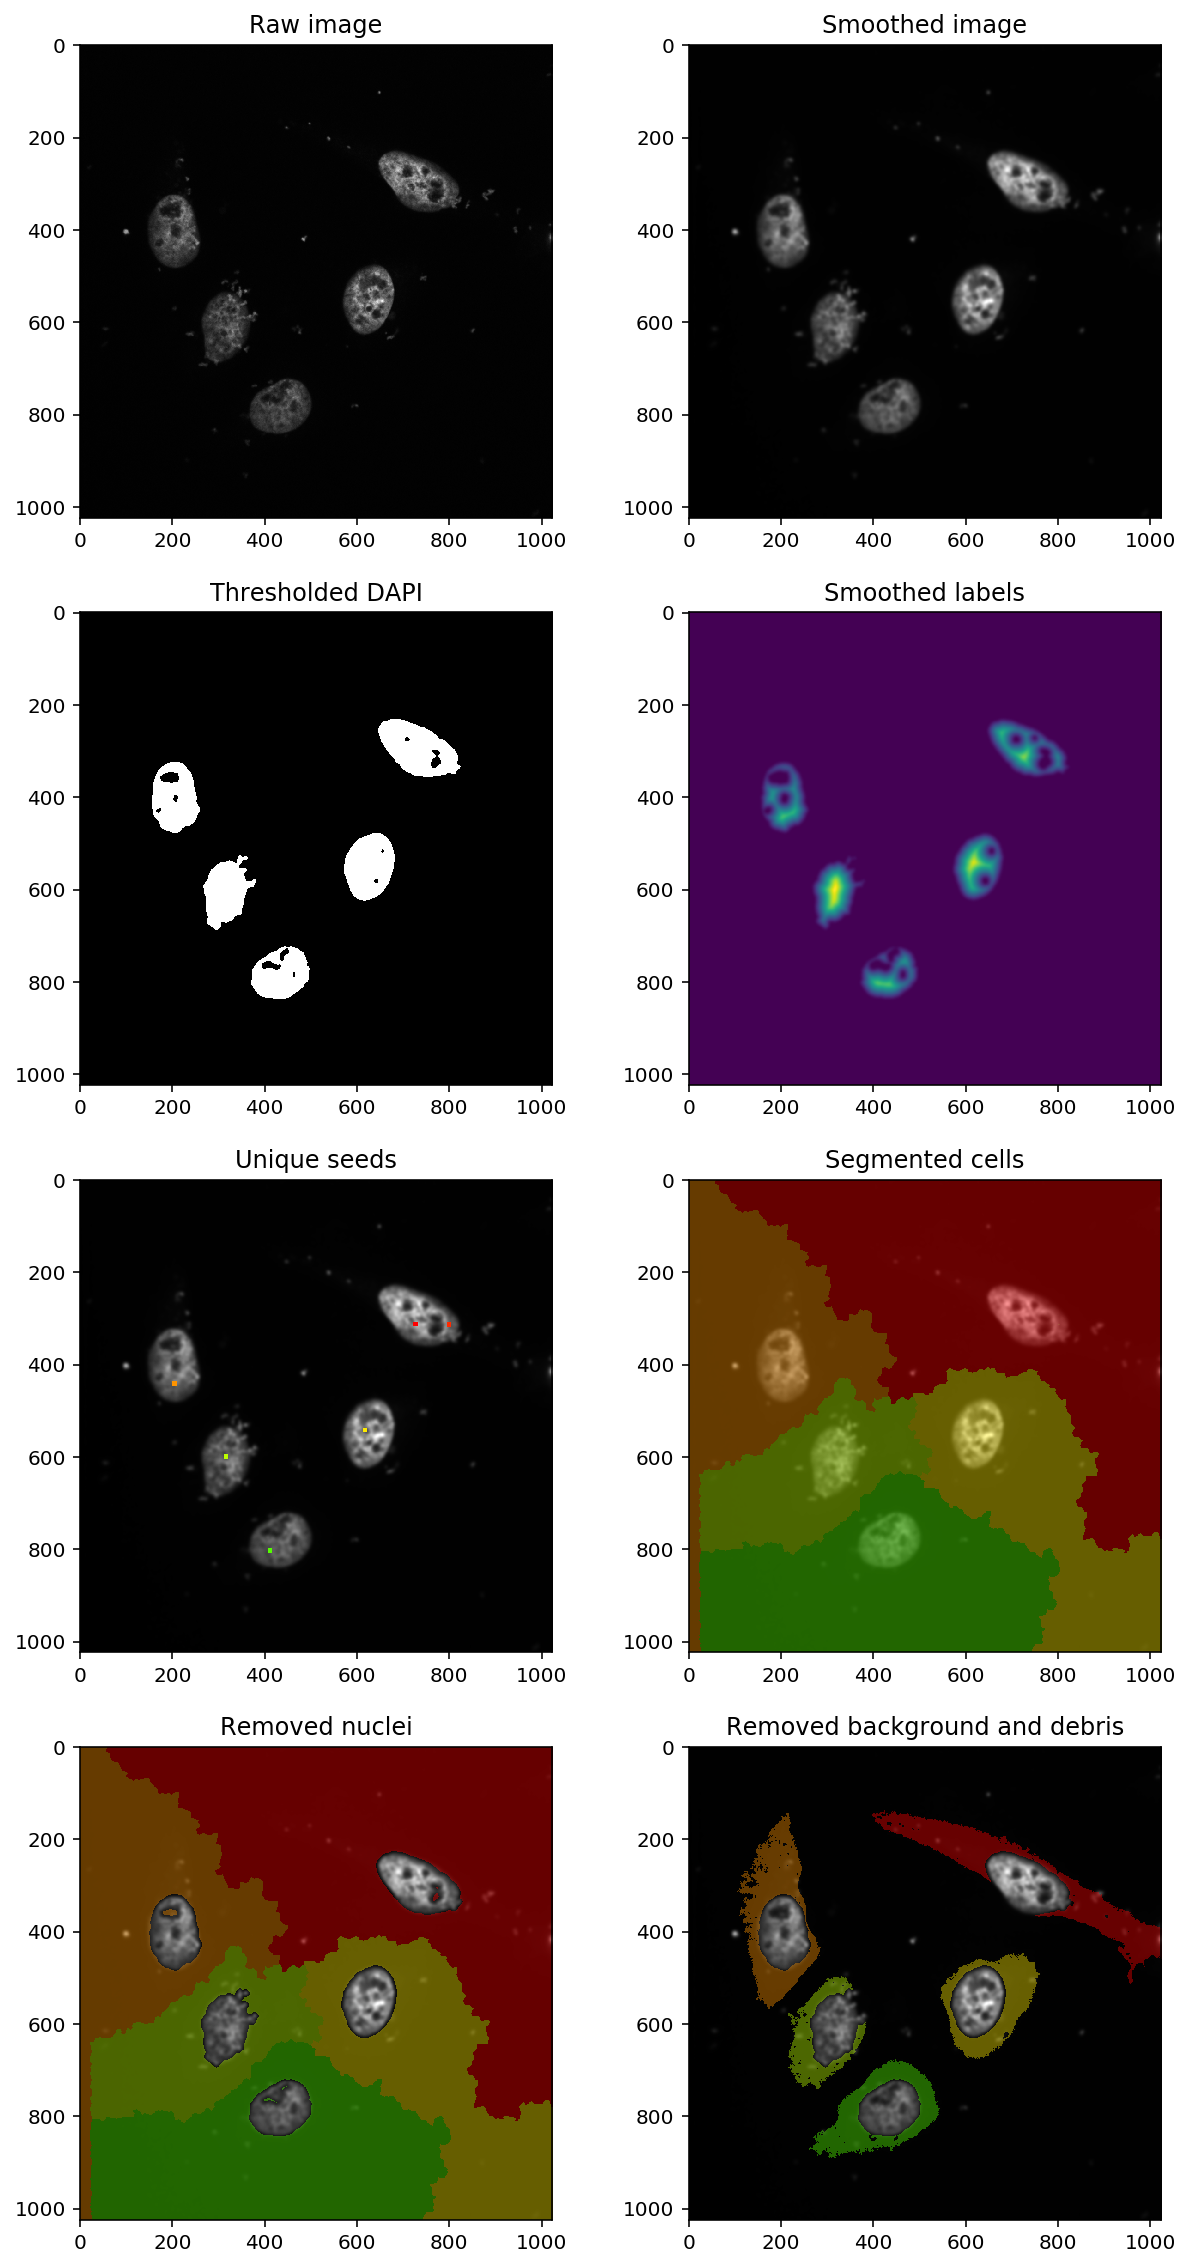

In [12]:
# Parameters for cellular segmentation
img0_sigma = 3
img0_min_size = 200
img0_min_distance = 50
img0_dilation = 5
img0_thresh_bg = 1000
img0_min_size_bg = 10_000

# Gauss-smoothening
img0_smooth = ndi.filters.gaussian_filter(img[0], img0_sigma)

# Thresholding and removal of small objects
img0_thresh = flt.threshold_otsu(img0_smooth)
img0_smooth_thresh = img0_smooth>img0_thresh
img0_mem = remove_small_objects(img0_smooth_thresh, img0_min_size)

# Labeling, euclidean distance transform, smoothing
img0_cell_labels, _ = ndi.label(img0_mem)
img0_dist_trans = ndi.distance_transform_edt(img0_mem)
img0_dist_trans_smooth = ndi.filters.gaussian_filter(img0_dist_trans, sigma=img0_sigma)

# Seeding (and dilating for visualization)
img0_seeds = peak_local_max(img0_dist_trans_smooth, indices=False, min_distance=img0_min_distance)
img0_seeds_labeled = ndi.label(img0_seeds)[0]
img0_seeds_labeled_dil = ndi.filters.maximum_filter(img0_seeds_labeled, size=10)

# Inverted watershed for segmentation
img0_seg = watershed(~img0_smooth, img0_seeds_labeled)

# Removal of dilated nuclei
img0_seg_nuclei = img0_seg * ~convolve2d(img0_mem.astype(int), dilate(img0_dilation).astype(int), mode='same').astype(bool)

# Removal of background based on colocalization channel 1
img0_thresh_bg = flt.threshold_triangle(img[1])
img0_smooth_thresh_bg = img[1]>img0_thresh_bg
img0_seg_clean = img0_seg_nuclei * img0_smooth_thresh_bg

# Removal of 'debris'
img0_seg_labeled, img0_seg_labels = ndi.measurements.label(img0_seg_clean)
img0_seg_label_size = [(img0_seg_labeled == label).sum() for label in range(img0_seg_labels + 1)]
for label, size in enumerate(img0_seg_label_size):
    if size < img0_min_size_bg:
        img0_seg_clean[img0_seg_labeled == label] = 0

# Visualization
fig, ax = plt.subplots(4, 2, figsize=(10, 20))
ax[0,0].set_title('Raw image')
ax[0,0].imshow(img[0], interpolation='none', cmap='gray')
ax[0,1].set_title('Smoothed image')
ax[0,1].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[1,0].set_title('Thresholded DAPI')
ax[1,0].imshow(img0_mem, interpolation='none', cmap='gray')
ax[1,1].set_title('Smoothed labels')
ax[1,1].imshow(img0_dist_trans_smooth, interpolation='none', cmap='viridis')
ax[2,0].set_title('Unique seeds')
ax[2,0].imshow(img0_dist_trans_smooth, interpolation='none', cmap='viridis')
ax[2,0].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[2,0].imshow(np.ma.array(img0_seeds_labeled_dil, mask=img0_seeds_labeled_dil==0), interpolation='none', cmap='prism')
ax[2,1].set_title('Segmented cells')
ax[2,1].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[2,1].imshow(np.ma.array(img0_seg, mask=img0_seg==0), interpolation='none', cmap='prism', alpha=0.4)
ax[3,0].set_title('Removed nuclei')
ax[3,0].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[3,0].imshow(np.ma.array(img0_seg_nuclei, mask=img0_seg_nuclei==0), interpolation='none', cmap='prism', alpha=0.4)
ax[3,1].set_title('Removed background and debris')
ax[3,1].imshow(img0_smooth, interpolation='none', cmap='gray')
ax[3,1].imshow(np.ma.array(img0_seg_clean, mask=img0_seg_clean==0), interpolation='none', cmap='prism', alpha=0.4)
plt.show()

<a id='section3'></a>
## 3. Colocalization analysis

The pearson correlation coefficient (PCC) can be used to quantify colocalization with a intensity weight. The equation is shown below.

\begin{align}
r = \frac{\sum_i\left(I_{1,i} - \bar{I}_1\right)\left(I_{2,i} - \bar{I}_2\right)}{\sqrt{\left(\sum_i \left(I_{1,i} - \bar{I}_1\right)^2\right)\left(\sum_i \left(I_{2,i} - \bar{I}_2\right)^2\right)}}.
\end{align}

The image set is tested for statistical relevance i.e. if the colocalization is greater than simple variance. This is done via scrambling small blocks of the image. The blocks' height and width are equal to the point spread function (PSF). The PCC is then calculated on the scrambled image blocks. The PSF can be approximated using the rayleigh criterion as follows.

\begin{align}
R_{\text{Widefield}} = \frac{0.6 \times \lambda}{\text{NA}} \quad R_{\text{Confocal}} = \frac{0.4 \times \lambda}{\text{NA}}
\end{align}

The edges are mirrored to obtain blocks that are multiples of the PSF. The widget below can be used to compare the effects of scrambling and background substraction on colocalization.

In [13]:
def mirror_edges(img, psf_width):
    '''
    Given a 2D image, boundaries are padded by mirroring so that
    the dimensions of the image are multiples for the width of the
    point spread function.
    '''
    # Required padding
    pad_i = psf_width - (img.shape[0] % psf_width)
    pad_j = psf_width - (img.shape[1] % psf_width)
    
    # Width of padding
    pad_top = pad_i // 2
    pad_bot = pad_i - pad_top
    pad_left = pad_j // 2
    pad_right = pad_j = pad_left
    
    # Numpy padding
    return np.pad(img, ((pad_top, pad_bot), (pad_left, pad_right)), mode='reflect')

In [14]:
def img_to_blocks(img, width, roi=None, roi_method='all'):
    '''
    Converts image to list of square subimages called 'blocks'.
    '''
    # ROI initialization
    if roi is None:
        roi = np.ones_like(img)
    
    # Method for determining if in ROI or not
    if roi_method == 'all':
        roi_test = np.all
    else:
        roi_test = np.any
        
    # Construction of block list
    return np.array([img[i:i + width, j:j + width]
                        for i in range(0, img.shape[0], width)
                            for j in range(0, img.shape[1], width)
                                if roi_test(roi[i:i + width, j:j + width])])

In [26]:
def scramble(blocks_1, blocks_2_flat, scrambles):
    '''
    Scrambles blocks_1 n_scramble times and returns the Pearson r values.
    '''
    r_scr = np.zeros(scrambles)
    for i in range(scrambles):
        random.shuffle(blocks_1)
        r, p = st.pearsonr(np.array(blocks_1).ravel(), blocks_2_flat)
        r_scr[i] = r
    r_scr = [i for i in r_scr if ~np.isnan(i)]
    return r_scr

In [24]:
def test_coloc(img1, img2, psf=100, scrambles=200):
    # Mirror edges
    img1_mirror = mirror_edges(img1, psf)
    img2_mirror = mirror_edges(img2, psf)

    # Generate blocks of both channels
    img1_blocks = img_to_blocks(img1_mirror, psf)
    img2_blocks = img_to_blocks(img2_mirror, psf)

    # Store blocks of channel 2 as flattened array (not scrambled)
    img2_blocks_flat = np.array(img2_blocks).flatten()

    # Unscrambled and scrambled R value(s)
    img1_unscr, p = st.pearsonr(np.array(img1_blocks).ravel(), img2_blocks_flat)
    img1_scr = scramble(img1_blocks, img2_blocks_flat, scrambles)
    print(img1_scr)
    
    # Visualization
    _ = sns.distplot(img1_scr, bins=int(np.sqrt(scrambles)))
    plt.plot([img1_unscr, img1_unscr], plt.gca().get_ylim(), '-')
    plt.title('Scrambled histogram vs. "real" image')
    plt.xlabel('Pearsons r-value')
    plt.show()

In [25]:
@interact(t_lambda = widgets.ToggleButtons(options=[488, 561, 640], value=640, description='Wavelength: '),
         t_na = widgets.ToggleButtons(options=[0.7, 1.4, 1.45], value=1.45, description='NA: '),
         t_bg = widgets.ToggleButtons(options=[True, False], description='Segmented: '),
         t_scrambles = widgets.IntSlider(min=0, max=2000, step=100, value=200, description='Scrambles: '))
def g(t_lambda, t_na, t_bg, t_scrambles):
    img1 = img[1] * img0_seg_clean
    img2 = img[2] * img0_seg_clean
    if t_bg == False:
        img1 = img[1]
        img2 = img[2]
    t_psf = int((0.4 * t_lambda) / t_na)
    test_coloc(img1, img2, t_psf, t_scrambles)

interactive(children=(ToggleButtons(description='Wavelength: ', index=2, options=(488, 561, 640), value=640), …

<a id='section4'></a>
## 4. Spot detection

To find optimal spot detection parameters in the second image channel, the widgets below can be used. In this pipeline, the spot detection is used filter out false positives. Cells, for example, which don't have any spots but seem to have significant colocalization values.

In [27]:
def test_spot_counter(image, sigma, block_size, thresh_abs, min_distance):
    # Set thresholds to reduce noise
    test_smooth = ndi.filters.gaussian_filter(image, sigma)
    thresh = flt.threshold_local(test_smooth, block_size, offset=0) 
    
    # Find and label seeds
    seeds = peak_local_max(thresh, indices=False, min_distance=min_distance, threshold_abs=thresh_abs)
    seeds_labeled = ndi.label(seeds)[0]
    seeds_labeled_dil = ndi.filters.maximum_filter(seeds_labeled, size=5) # Dilates seeds – more visible
    seeds_masked_labeled = np.ma.array(seeds_labeled_dil, mask=seeds_labeled_dil==0)
    seeds_unique = len(np.unique(seeds_labeled_dil)[1:])
    
    # Visualization
    plt.figure(figsize=(10, 10))
    plt.title('Detected spots')
    plt.imshow(image, interpolation='none', cmap='gray')
    plt.imshow(seeds_masked_labeled, interpolation='none', cmap='prism', alpha=0.5)
    print('Unique spots:', seeds_unique)

In [28]:
@interact(t_img = widgets.ToggleButtons(options=['1', '2'], description='Channel: '),
         t_sigma = widgets.IntSlider(min=0, max=20, step=1, value=1, description='Sigma: '),
         t_block_size = widgets.IntSlider(min=1, max=21, step=2, value=5, description='Block size: '),
         t_thresh_abs = widgets.IntSlider(min=0, max=15_000, step=100, value=7_000, description='Treshold: '),
         t_min_distance = widgets.IntSlider(min=0, max=30, step=1, value=5, description='Min. dist.: '))
def g(t_img, t_sigma, t_block_size, t_thresh_abs, t_min_distance):
    t_img_ = img[int(t_img)]
    test_spot_counter(t_img_, t_sigma, t_block_size, t_thresh_abs, t_min_distance)

interactive(children=(ToggleButtons(description='Channel: ', options=('1', '2'), value='1'), IntSlider(value=1…

<a id='section5'></a>
## 5. Cell-to-cell measurements

The colocalization and spot detection functions will be used to record their respective output on a cellular basis. In order to track the settings used for the analysis, all parameters are saved together with the measurements. Prior to the measurements, the background will be substracted as represented above ([DAPI-gated cellular segmentation](#section2)). All values are combined and stored in a .csv file.

In [13]:
# Parameters for spot detection and colocalization
img1 = img[1]
img1_sigma = 1
img1_block_size = 5
img1_min_distance = 0
img1_thresh = 5000

img2 = img[2]
img2_sigma = 1
img2_block_size = 5
img2_min_distance = 0
img2_thresh = 5000

psf_lambda = 648
psf_na = 1.45
psf = int((0.4 * psf_lambda) / psf_na)
scrambles = 1000

In [14]:
def coloc(img1, img2, psf=3, scrambles=1000):
    '''
    Colocalization of two images and comparison with scrambles.
    Parameters
    ----------
    img1: nd.array
        Image array of to be scrambled image.
    img2: nd.array
        Image array of the 'static' image.
    psf: int, default 3
        Point spread function of the longer wavelength.
    scrambles: int, default 1000
        Number of scrambles to calculate r value of.
    Returns
    ----------
    outputs: float, list of floats
        R values (unscrambled (float) and scrambled(list of floats))
    '''
    # Mirror edges
    img1_mirror = mirror_edges(img1, psf)
    img2_mirror = mirror_edges(img2, psf)

    # Generate blocks of both channels
    img1_blocks = img_to_blocks(img1_mirror, psf)
    img2_blocks = img_to_blocks(img2_mirror, psf)

    # Store blocks of channel 2 as flattened array (not scrambled)
    img2_blocks_flat = np.array(img2_blocks).flatten()

    # Scamblin' and obtain R value
    img1_scr = scramble(img1_blocks, img2_blocks_flat, scrambles)
    
    # Unscrambled R value
    img1_unscr, p = st.pearsonr(np.array(img1_blocks).ravel(), img2_blocks_flat)
    
    return img1_unscr, img1_scr

In [15]:
def spot_counter(img_, block_size=1, threshold=0, min_distance=0):
    '''
    Counts spots returning the number of unique spots in a given area.
    Parameters
    ----------
    img_: np.array.shape(x, x)
        Image on which spots should be counted.
    block_size: int, default 0
        Odd size of pixel neighborhood to perform a local threshold.
    threshold: int, default 0
        Local maximum threshold filtering out any lower values.
    min_distance: int, default 0
        Minimum distance between two potential spots.
    Returns
    ----------
    output: int
        Unique seed count.
    '''
    thresh = flt.threshold_local(img_, block_size, offset=5) 
    seeds = peak_local_max(thresh, indices=False, min_distance=min_distance)
    seeds_labeled = ndi.label(seeds)[0]
    seeds_unique = len(np.unique(seeds_labeled)[1:]) # '0' to not include background
    return seeds_unique

In [16]:
results = {'filename'                 : [],
           'cell_ID'                  : [],
           
           # Measurements
           'cell_area'                : [],
           'img1_cell_intensity_mean' : [],
           'img1_cell_intensity_std'  : [],
           'img1_spot_count'          : [],
           'img2_cell_intensity_mean' : [],
           'img2_cell_intensity_std'  : [],
           'img2_spot_count'          : [],
           'img1_2_coloc_org'         : [],
           'img1_2_coloc_scr'         : [],
           
           # Parameters
           'psf'                      : [],
           'scrambles'                : [],
           'img0_sigma'               : [],
           'img0_min_size'            : [],
           'img0_min_distance'        : [],
           'img0_dilation'            : [],
           'img0_thresh_bg'           : [],
           'img0_min_size_bg'         : [],
           'img1_sigma'               : [],
           'img1_block_size'          : [],
           'img1_min_distance'        : [],
           'img1_thresh'              : [],
           'img2_sigma'               : [],
           'img2_block_size'          : [],
           'img2_min_distance'        : [],
           'img2_thresh'              : []}
        
# Smoothing for spot detection
img1_smooth = ndi.filters.gaussian_filter(img1, img1_sigma)
img2_smooth = ndi.filters.gaussian_filter(img2, img2_sigma)

for cell_ID in np.unique(img0_seg_clean)[1:]:
    img0_cell_mask = img0_seg_clean==cell_ID

    # Area measurement on cell mask
    cell_area = np.count_nonzero(img0_cell_mask)

    # Intensity and spot count measurements
    img1_cell = np.where(np.ma.array(img0_cell_mask, mask=img0_cell_mask==0), img1_smooth, 0)
    img1_cell_intensity_mean = np.mean(np.nonzero(img1_cell))
    img1_cell_intensity_std = np.std(np.nonzero(img1_cell))
    img1_spot_count = spot_counter(img1_cell, img1_block_size, img1_thresh, img1_min_distance)
    img2_cell = np.where(np.ma.array(img0_cell_mask, mask=img0_cell_mask==0), img2_smooth, 0)
    img2_cell_intensity_mean = np.mean(np.nonzero(img2_cell))
    img2_cell_intensity_std = np.std(np.nonzero(img2_cell))
    img2_spot_count = spot_counter(img2_cell, img2_block_size, img2_thresh, img2_min_distance)

    # Colocalization measurements  
    img1_2_coloc_scr, img1_2_coloc_org = coloc((img1*img0_cell_mask), (img2*img0_cell_mask), psf, scrambles)

    results['filename'].append(os.path.basename(os.path.normpath(root)))
    results['cell_ID'].append(cell_ID)

    # Measurements
    results['cell_area'].append(cell_area)
    results['img1_cell_intensity_mean'].append(img1_cell_intensity_mean)
    results['img1_cell_intensity_std'].append(img1_cell_intensity_std)
    results['img1_spot_count'].append(img1_spot_count)
    results['img2_cell_intensity_mean'].append(img2_cell_intensity_mean)
    results['img2_cell_intensity_std'].append(img2_cell_intensity_std)
    results['img2_spot_count'].append(img2_spot_count)
    results['img1_2_coloc_org'].append(img1_2_coloc_org)
    results['img1_2_coloc_scr'].append(img1_2_coloc_scr)

    # Parameters
    results['psf'].append(psf)
    results['scrambles'].append(scrambles)
    results['img0_sigma'].append(img0_sigma)
    results['img0_min_size'].append(img0_min_size)
    results['img0_min_distance'].append(img0_min_distance)
    results['img0_dilation'].append(img0_dilation)
    results['img0_thresh_bg'].append(img0_thresh_bg)
    results['img0_min_size_bg'].append(img0_min_size_bg)
    results['img1_sigma'].append(img1_sigma)
    results['img1_block_size'].append(img1_block_size)
    results['img1_min_distance'].append(img1_min_distance)
    results['img1_thresh'].append(img1_thresh)
    results['img2_sigma'].append(img2_sigma)
    results['img2_block_size'].append(img2_block_size)
    results['img2_min_distance'].append(img2_min_distance)
    results['img2_thresh'].append(img2_thresh)

    # Export results
    with open(''.join([files[0], '.csv']),'w') as outfile:
        header_string = '\t'.join(results.keys()) + '\n'
        outfile.write(header_string)
        for index in range(len(results['filename'])):
            data_string = '\t'.join([str(results[key][index]) for key in results.keys()]) + '\n'
            outfile.write(data_string)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<a id='section6'></a>
## 6. Batch processing

Batch processing means running complete pipeline over multiple images. The run_pipeline function is located in the file colocalization.py together with all dependencies and helper functions. The documentation is as follows.

```python
def run_pipeline(index, root, outfolder):
'''
Runs a colocalization and spot detection pipeline.
Parameters
----------
index: str
    Base name / index for one set of image files.
root: dir
    Directory where image files are located.
outfolder: dir
    Directory for output.
Returns
----------
outfolder/index.csv: .csv file
    File with all values in the outfolder.
'''
```

In [17]:
from colocalization import run_pipeline

# File path
root = 'colocalization_example/'
outfolder = 'colocalization_example/'

# Indices based on the .nd files
indices = [file.split('.')[0] for file in os.listdir(root) if file.endswith('.nd')]

# Batch processing
for i in indices:
    files = glob.glob('{}{}*.stk'.format(root, i))
    run_pipeline(files, root, outfolder)
    print(f'{indices.index(i) + 1}/{len(indices)} complete')

1/1 complete


<a id='section7'></a>
## 7. EDA and visualization

Once all images have been processed, they are imported as pandas dataframe. After some data cleaning, a suitable form of visualization is used to pinpoint the key features.

<a id='section8'></a>
## 8. Functions

Additional functions which can be used as alternative. Furthermore, for the full documentation on all functions above, check the colocalization.py file.